In [2]:
import torch
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torch.nn as nn

import argparse
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import cv2
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import datetime as dt

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

import psutil
import GPUtil as GPU
import csv

from device_info_writer import all_device_info_csv_writer
import config

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 後でコマンドライン引数にするパラメータ
EPOCHS = 300
BATCH_SIZE = 32
LR = 0.0001
MODEL_FILE = "./CommonCnn.py"
DATA_AUG_FAC = 0

plt.style.use("ggplot")

In [4]:
def train_test_split(csv_path,split):
    df_data = pd.read_csv(csv_path,header=None)
    df_data = df_data.dropna()
    len_data = len(df_data)
    valid_split = int(len_data * split)
    train_split = int(len_data - valid_split)
    training_samples = df_data.iloc[:train_split][:]
    valid_samples = df_data.iloc[-valid_split:][:]
    print(f"Training sample instances: {len(training_samples)}")
    print(f"Validation sample instances: {len(valid_samples)}")
    return training_samples,valid_samples

In [26]:
def print_division_patterns(num):
    remainder_list = []
    for i in range(1, num + 1):
        quotient, _ = divmod(num, i)
        remainder_list.append(quotient)
    remainder_list_sorted = sorted(set(remainder_list), reverse=True)
    print(remainder_list_sorted)
    return remainder_list_sorted

print_division_patterns(461)

[461, 230, 153, 115, 92, 76, 65, 57, 51, 46, 41, 38, 35, 32, 30, 28, 27, 25, 24, 23, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [4]:
def AugmentFaceKeypointDataset(training_samples,data_path,aug_data_num):
    # first_column = training_samples.iloc[:, 0]
    data_set_list = []
    # data_num = 1
    for data_num in range(training_samples.shape[0]):
        image = cv2.imread(f"{data_path}/{training_samples.iloc[data_num, 0]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h,orig_w,_ = image.shape
        # print(type(image))
        # 画像を表示

        # About keypoint
        keypoints = training_samples.iloc[data_num][1:]
        keypoints = np.array(keypoints,dtype="float32")
        keypoints = keypoints.reshape(-1,2)
        keypoints = keypoints * [config.RESIZE / orig_w, config.RESIZE / orig_h]

        data_set_list.append([image,keypoints])


        # データ拡張枚数が0枚の場合はデータ拡張の部分をスキップする
        if aug_data_num == 0:
            continue

        kps = KeypointsOnImage([
            Keypoint(x=keypoints[0][0], y=keypoints[0][1]),
            Keypoint(x=keypoints[1][0], y=keypoints[1][1]),
            Keypoint(x=keypoints[2][0], y=keypoints[2][1]),
            Keypoint(x=keypoints[3][0], y=keypoints[3][1]),
            Keypoint(x=keypoints[4][0], y=keypoints[4][1]),
            Keypoint(x=keypoints[5][0], y=keypoints[5][1]),
            Keypoint(x=keypoints[6][0], y=keypoints[6][1]),
            Keypoint(x=keypoints[7][0], y=keypoints[7][1]),
            Keypoint(x=keypoints[8][0], y=keypoints[8][1])
        ], shape=image.shape)

        # About Augment setting
        seq = iaa.Sequential([
            iaa.ShearX((-30, 30)),
            iaa.Multiply((0.8, 1.3)), # change brightness, doesn't affect keypoints
            iaa.Affine(
                rotate=(-50,50),
                scale={"x": (0.5, 1.2), "y": (0.5, 1.2)},
                cval=(10, 255)
            ) ,
            iaa.Invert(0.05, per_channel=0.5),
            iaa.Fliplr(0.5),
            iaa.RemoveSaturation((0,0.5)),
            iaa.AddToHueAndSaturation((-50, 50), per_channel=True),
            iaa.UniformColorQuantizationToNBits(),
            iaa.AdditiveGaussianNoise(scale=[0, 10]),
        ])

        for aug_count in  range(aug_data_num):
            image_aug, kps_aug = seq(image=image, keypoints=kps)
            keypoints = []
            for i in range(len(kps.keypoints)):
                before = kps.keypoints[i]
                after = kps_aug.keypoints[i]
                keypoints.append([after.x,after.y])
                # print(after.x)
            keypoints = np.array(keypoints,dtype="float32")
            # print(keypoints)

            image_after = kps_aug.draw_on_image(image_aug,size=0)

            # データ拡張を行った画像をリストに格納する
            data_set_list.append([image_after,keypoints])

            # 描画
            # plt.imshow(image_after)
            # plt.scatter(keypoints[:,0], keypoints[:,1], color='r')
            # plt.show()
    return data_set_list

In [5]:
def fit(model, dataloader, data,optimizer,criterion):
    # print("training")
    model.train()
    train_running_loss = 0.0
    counter = 0
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader),total=num_batches):
        counter += 1
        image, keypoints = data["image"].to(config.DEVICE), data["keypoints"].to(config.DEVICE)
        keypoints = keypoints.view(keypoints.size(0),-1)
        # print(keypoints)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs,keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / counter
    return train_loss

In [6]:
def validate(model,dataloader,data,criterion):
    # print("validate")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    num_batches = int(len(data) / dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader),total=num_batches):
            counter += 1
            image, keypoints = data["image"].to(config.DEVICE),data["keypoints"].to(config.DEVICE)
            keypoints = keypoints.view(keypoints.size(0),-1)
            outputs = model(image)
            loss = criterion(outputs,keypoints)
            valid_running_loss += loss.item()
            # if (epoch + 1) % 25 == 0 and i == 0:
    valid_loss = valid_running_loss / counter
    return valid_loss

In [7]:
def record_progress_vram_information(file_name,epoch_num,start_time,lap_time,train_loss,valid_loss):
    gpu = GPU.getGPUs()[0]
    mem_info = psutil.virtual_memory()
    used_gpu_memory = str(gpu.memoryUsed)
    free_gpu_memory = str(gpu.memoryFree)
    memory_percentage = str(mem_info.percent)
    current_gpu_power_consumption = str(os.popen("nvidia-smi --query-gpu=power.draw --format=csv,noheader").read().replace("\n","").replace(" W",""))
    gpu_temperature = str(gpu.temperature)
    with open(str(file_name),"a") as f:
        writer = csv.writer(f)

        # ヘッダがなければ書き込む
        if not os.path.isfile(file_name) or os.stat(file_name).st_size == 0:
            header = ["epoch_num","start_time","lap_time","train_loss","valid_loss","used_gpu_memory","free_gpu_memory","memory_percentage","current_gpu_power_consumption","gpu_temperature"]
            writer.writerow(header)

        write_content = [epoch_num,start_time,lap_time,train_loss,valid_loss,used_gpu_memory,free_gpu_memory,memory_percentage,current_gpu_power_consumption,gpu_temperature]
        writer.writerow(write_content)
    return write_content

In [8]:
# 記録データを格納するディレクトリの作成
# 日付と時間を年月日時分秒の形式にフォーマット
now = datetime.now()
now_str = str(now.strftime("%Y%m%d%H%M"))
model_name = str(MODEL_FILE).replace("./","").replace(".py","")
info_dir_name = "test_" + now_str + f"_{model_name}"
print(info_dir_name)
# ディレクトリのパスを設定 (現在のスクリプトの位置に作成)
# 今後記録はこのディレクトリに入れる
info_dir_path = os.path.join(os.getcwd(), info_dir_name)

# ディレクトリを作成
os.makedirs(info_dir_path, exist_ok=True)

# 指定のディレクトリにマシンの情報を記録する
all_device_info_csv_writer(f"{info_dir_path}/{now_str}_DeviceInfo.csv")

test_202306061742_CommonCnn


[[['Time Information'],
  ['UTC', '2023-06-06 08:42:59.677573+00:00'],
  ['JST', '2023-06-06 17:42:59.694445+09:00']],
 [['System Information'],
  ['System', 'Linux'],
  ['Node Name', '2af8d13e21d5'],
  ['Release', '5.10.0-22-amd64'],
  ['Version', '#1 SMP Debian 5.10.178-3 (2023-04-22)']],
 [['CPU Information'],
  ['CPU', 'Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz'],
  ['Processor', 'x86_64'],
  ['Physical cores', '18'],
  ['Total cores', '36'],
  ['Max Frequency(Mhz)', '4633.33'],
  ['Min Frequency(Mhz)', '1200.00'],
  ['Current Frequency(Mhz)', '3380.15'],
  ['Total CPU Usage(%)', '55.0']],
 [['GPU Information'],
  ['GPU name', 'NVIDIA GeForce RTX 3090'],
  ['NVIDIA Driver Version', '470.182.03'],
  ['CUDA Version', '11.4'],
  ['Total GPU memory', '24268.0'],
  ['Used GPU memory', '5502.0'],
  ['Free GPU memory', '18766.0'],
  ['Memory percentage', '26.2'],
  ['Maximum GPU power consumption', '350.00 W'],
  ['Current GPU power consumption', '132.53 W'],
  ['GPU temperature', '60.0'

In [9]:
# csvファイルを見て、トレーニングデータとバリデーションデータを分ける
# training_samples,valid_samples = train_test_split(f"{str(config.DATASET_PATH)}/annotations/annotation_from_xml.csv",config.TEST_SPLIT)
training_samples,valid_samples = train_test_split(f"/root/dataset/Annotated_High-Resolution_Anime/annotations/annotation_from_xml.csv",config.TEST_SPLIT)
training_samples

Training sample instances: 437
Validation sample instances: 48


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,10000310.jpg,115.97,298.27,264.70,398.60,122.64,348.51,157.53,384.36,202.38,409.78,314.26,373.97,348.48,328.99,363.52,276.01,109.18,250.23
1,1000050.jpg,188.82,363.66,366.81,294.72,371.96,244.08,267.75,395.64,226.64,382.22,164.09,332.26,153.12,287.41,348.37,341.99,314.68,374.39
2,10000760.jpg,330.06,399.94,145.02,320.96,196.06,393.08,240.18,415.46,284.66,428.42,367.74,359.34,380.52,305.73,378.99,238.40,167.41,356.80
3,10000990.jpg,344.38,293.29,332.73,334.41,311.03,374.69,270.52,398.45,217.05,417.46,173.04,389.56,135.14,351.51,127.26,308.89,125.85,256.52
4,10001010.jpg,320.07,404.20,287.40,422.63,243.11,434.33,191.76,435.80,159.74,394.54,134.86,353.07,143.20,298.45,164.00,236.68,350.73,366.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,32532710.jpg,184.27,389.18,269.46,376.06,305.72,348.60,322.07,304.27,324.32,255.35,117.09,279.73,133.28,323.01,149.08,361.42,227.92,401.64
433,32533170.jpg,160.84,412.76,345.18,285.94,120.56,330.24,140.87,374.30,201.55,429.82,248.88,440.33,289.87,413.35,337.93,336.29,320.54,381.34
434,3772650.jpg,115.98,326.89,285.39,390.52,208.90,411.47,251.01,429.55,337.34,274.44,337.33,324.42,169.67,396.84,140.18,365.76,318.90,361.39
435,3773580.jpg,177.72,353.85,150.94,319.08,337.32,342.71,301.16,366.38,261.85,380.38,206.83,386.00,366.68,311.07,145.55,229.92,138.34,278.50


In [10]:
# csvファイルを見て、トレーニングデータとバリデーションデータを分ける
# training_samples,valid_samples = train_test_split(f"{str(config.DATASET_PATH)}/annotations/annotation_from_xml.csv",config.TEST_SPLIT)
# training_samples,valid_samples = train_test_split(f"/root/source/Archive/20230529/face_keypoints_data.csv",config.TEST_SPLIT)
# training_samples

In [11]:
train_numpy_dataset = AugmentFaceKeypointDataset(training_samples,f"{config.DATASET_PATH}/images",DATA_AUG_FAC)
# train_numpy_dataset[0]

In [12]:
class FaceKeypointDataset(Dataset):
    def __init__(self,dataset,resize):
        self.data = dataset
        self.resize = resize

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index][0]
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        orig_h,orig_w,_ = image.shape
        image = cv2.resize(image,(self.resize,self.resize))

        # print(orig_h,orig_w)
        # 画素値を0~1に変換
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))
        # print(image.shape)
        keypoints = self.data[index][1]
        # keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]

        # ランドマークの座標を画像のサイズで割ることで、割合に変換している
        # keypoints[:, 0] *= (self.resize / orig_w)
        # keypoints[:, 1] *= (self.resize / orig_h)
        # print(keypoints)

        keypoint_data = {
            "image": torch.tensor(image, dtype=torch.float),
            "keypoints": torch.tensor(keypoints,dtype=torch.float)
        }
        
        return keypoint_data

In [13]:
train_tensor_data = FaceKeypointDataset(train_numpy_dataset,config.RESIZE)
train_tensor_data[0]["image"].shape

torch.Size([3, 224, 224])

In [14]:
train_loader = DataLoader(train_tensor_data,batch_size=BATCH_SIZE,shuffle=True)
train_loader

In [15]:
# データ拡張を行い、numpyで返す
train_numpy_dataset = AugmentFaceKeypointDataset(training_samples,f"{config.DATASET_PATH}/images",DATA_AUG_FAC)
valid_numpy_dataset = AugmentFaceKeypointDataset(valid_samples,f"{config.DATASET_PATH}/images",DATA_AUG_FAC)

train_tensor_data = FaceKeypointDataset(train_numpy_dataset,config.RESIZE)
valid_tensor_data = FaceKeypointDataset(valid_numpy_dataset,config.RESIZE)
# print(train_tensor_data[0])

train_loader = DataLoader(train_tensor_data,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_tensor_data,batch_size=BATCH_SIZE,shuffle=True)

module = importlib.import_module(model_name)
# モジュール内のクラスを取得
FaceKeypointModel = getattr(module, 'FaceKeypointModel')

model = FaceKeypointModel().to(config.DEVICE)
print(model)
optimizer = optim.Adam(model.parameters(),lr=LR)
criterion = nn.MSELoss()

FaceKeypointModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=18, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
)


Epoch 1 of 300


14it [00:03,  4.28it/s]                        
2it [00:00, 18.31it/s]               


Train Loss: 18744.9591
Val Loss: 19514.3174
Epoch 2 of 300


14it [00:01, 13.10it/s]                        
2it [00:00, 17.59it/s]               


Epoch 3 of 300


14it [00:01, 13.26it/s]                        
2it [00:00, 16.75it/s]               


Epoch 4 of 300


14it [00:01, 13.25it/s]                        
2it [00:00, 26.35it/s]               


Epoch 5 of 300


14it [00:01, 13.09it/s]                        
2it [00:00, 21.73it/s]               


Epoch 6 of 300


14it [00:01, 13.69it/s]                        
2it [00:00, 15.83it/s]               


Epoch 7 of 300


14it [00:01, 13.38it/s]                        
2it [00:00, 18.61it/s]               


Epoch 8 of 300


14it [00:01, 13.03it/s]                        
2it [00:00, 17.75it/s]               


Epoch 9 of 300


14it [00:01, 12.78it/s]                        
2it [00:00, 20.87it/s]               


Epoch 10 of 300


14it [00:00, 14.23it/s]                        
2it [00:00, 17.21it/s]               


Epoch 11 of 300


14it [00:01, 12.84it/s]                        
2it [00:00, 16.81it/s]               


Epoch 12 of 300


14it [00:00, 14.39it/s]                        
2it [00:00, 18.78it/s]               


Epoch 13 of 300


14it [00:01, 13.21it/s]                        
2it [00:00, 16.70it/s]               


Epoch 14 of 300


14it [00:01, 11.82it/s]                        
2it [00:00, 18.24it/s]               


Epoch 15 of 300


14it [00:00, 15.87it/s]                        
2it [00:00, 18.13it/s]               


Epoch 16 of 300


14it [00:01, 13.30it/s]                        
2it [00:00, 17.09it/s]               


Epoch 17 of 300


14it [00:01, 13.15it/s]                        
2it [00:00, 17.81it/s]               


Epoch 18 of 300


14it [00:01, 13.23it/s]                        
2it [00:00, 19.59it/s]               


Epoch 19 of 300


14it [00:01, 13.96it/s]                        
2it [00:00, 14.40it/s]                       


Epoch 20 of 300


14it [00:01, 12.62it/s]                        
2it [00:00, 19.50it/s]               


Epoch 21 of 300


14it [00:01, 12.18it/s]                        
2it [00:00, 21.40it/s]               


Epoch 22 of 300


14it [00:01, 12.45it/s]                        
2it [00:00, 22.17it/s]               


Epoch 23 of 300


14it [00:01, 13.37it/s]                        
2it [00:00, 17.71it/s]               


Epoch 24 of 300


14it [00:01, 13.36it/s]                        
2it [00:00, 15.84it/s]               


Epoch 25 of 300


14it [00:01, 13.54it/s]                        
2it [00:00, 18.73it/s]               


Epoch 26 of 300


14it [00:01, 13.03it/s]                        
2it [00:00, 16.77it/s]               


Train Loss: 1554.3596
Val Loss: 1691.4326
Epoch 27 of 300


14it [00:01, 12.83it/s]                        
2it [00:00, 21.79it/s]               


Epoch 28 of 300


14it [00:01, 13.51it/s]                        
2it [00:00, 17.31it/s]               


Epoch 29 of 300


14it [00:01, 12.76it/s]                        
2it [00:00, 17.13it/s]               


Epoch 30 of 300


14it [00:01, 12.72it/s]                        
2it [00:00, 24.27it/s]               


Epoch 31 of 300


14it [00:01, 12.78it/s]                        
2it [00:00, 18.92it/s]               


Epoch 32 of 300


14it [00:01, 12.82it/s]                        
2it [00:00, 18.68it/s]               


Epoch 33 of 300


14it [00:01, 13.24it/s]                        
2it [00:00, 19.04it/s]               


Epoch 34 of 300


14it [00:01, 12.17it/s]                        
2it [00:00, 21.46it/s]               


Epoch 35 of 300


14it [00:01, 12.28it/s]                        
2it [00:00, 28.17it/s]               


Epoch 36 of 300


14it [00:01, 12.93it/s]                        
2it [00:00, 17.90it/s]               


Epoch 37 of 300


14it [00:01, 12.65it/s]                        
2it [00:00, 15.78it/s]               


Epoch 38 of 300


14it [00:01, 12.57it/s]                        
2it [00:00, 14.95it/s]               


Epoch 39 of 300


14it [00:00, 14.36it/s]                        
2it [00:00, 19.05it/s]               


Epoch 40 of 300


14it [00:01, 12.35it/s]                        
2it [00:00, 19.37it/s]               


Epoch 41 of 300


14it [00:01, 13.14it/s]                        
2it [00:00, 18.95it/s]               


Epoch 42 of 300


14it [00:01, 12.84it/s]                        
2it [00:00, 18.86it/s]               


Epoch 43 of 300


14it [00:01, 12.83it/s]                        
2it [00:00, 19.73it/s]               


Epoch 44 of 300


14it [00:01, 12.79it/s]                        
2it [00:00, 16.19it/s]               


Epoch 45 of 300


14it [00:01, 12.81it/s]                        
2it [00:00, 18.48it/s]               


Epoch 46 of 300


14it [00:01, 13.85it/s]                        
2it [00:00, 23.00it/s]               


Epoch 47 of 300


14it [00:01, 12.69it/s]                        
2it [00:00, 20.02it/s]               


Epoch 48 of 300


14it [00:01, 13.15it/s]                        
2it [00:00, 18.08it/s]               


Epoch 49 of 300


14it [00:01, 12.75it/s]                        
2it [00:00, 14.85it/s]               


Epoch 50 of 300


14it [00:01, 13.54it/s]                        
2it [00:00, 16.03it/s]               


Epoch 51 of 300


14it [00:01, 12.32it/s]                        
2it [00:00, 18.26it/s]               


Train Loss: 1529.5986
Val Loss: 1624.9383
Epoch 52 of 300


14it [00:00, 14.22it/s]                        
2it [00:00, 21.86it/s]               


Epoch 53 of 300


14it [00:01, 12.42it/s]                        
2it [00:00, 22.95it/s]               


Epoch 54 of 300


14it [00:01, 13.08it/s]                        
2it [00:00, 20.00it/s]               


Epoch 55 of 300


14it [00:01, 13.30it/s]                        
2it [00:00, 20.29it/s]               


Epoch 56 of 300


14it [00:00, 14.18it/s]                        
2it [00:00, 19.74it/s]               


Epoch 57 of 300


14it [00:01, 12.80it/s]                        
2it [00:00, 14.63it/s]               


Epoch 58 of 300


14it [00:01, 13.85it/s]                        
2it [00:00, 15.05it/s]                       


Epoch 59 of 300


14it [00:01, 12.40it/s]                        
2it [00:00, 16.64it/s]               


Epoch 60 of 300


14it [00:01, 13.22it/s]                        
2it [00:00, 17.55it/s]               


Epoch 61 of 300


14it [00:00, 14.13it/s]                        
2it [00:00, 17.68it/s]               


Epoch 62 of 300


14it [00:01, 13.24it/s]                        
2it [00:00, 20.27it/s]               


Epoch 63 of 300


14it [00:01, 13.35it/s]                        
2it [00:00, 16.63it/s]               


Epoch 64 of 300


14it [00:01, 12.78it/s]                        
2it [00:00, 12.82it/s]                       


Epoch 65 of 300


14it [00:01, 12.74it/s]                        
2it [00:00, 16.19it/s]               


Epoch 66 of 300


14it [00:01, 13.35it/s]                        
2it [00:00, 15.18it/s]               


Epoch 67 of 300


14it [00:01, 13.16it/s]                        
2it [00:00, 17.73it/s]               


Epoch 68 of 300


14it [00:01, 12.80it/s]                        
2it [00:00, 18.96it/s]               


Epoch 69 of 300


14it [00:01, 12.88it/s]                        
2it [00:00, 17.78it/s]               


Epoch 70 of 300


14it [00:01, 12.40it/s]                        
2it [00:00, 16.61it/s]               


Epoch 71 of 300


14it [00:00, 14.32it/s]                        
2it [00:00, 19.46it/s]               


Epoch 72 of 300


14it [00:01, 12.28it/s]                        
2it [00:00, 15.47it/s]               


Epoch 73 of 300


14it [00:01, 12.69it/s]                        
2it [00:00, 17.66it/s]               


Epoch 74 of 300


14it [00:01, 12.56it/s]                        
2it [00:00, 19.99it/s]               


Epoch 75 of 300


14it [00:01, 12.33it/s]                        
2it [00:00, 18.58it/s]               


Epoch 76 of 300


14it [00:01, 12.30it/s]                        
2it [00:00, 16.84it/s]               


Train Loss: 1488.9041
Val Loss: 1570.0237
Epoch 77 of 300


14it [00:01, 12.17it/s]                        
2it [00:00, 20.59it/s]               


Epoch 78 of 300


14it [00:01, 12.80it/s]                        
2it [00:00, 20.28it/s]               


Epoch 79 of 300


14it [00:01, 13.48it/s]                        
2it [00:00, 20.72it/s]               


Epoch 80 of 300


14it [00:01, 11.58it/s]                        
2it [00:00, 26.85it/s]               


Epoch 81 of 300


14it [00:01, 13.11it/s]                        
2it [00:00, 12.59it/s]                       


Epoch 82 of 300


14it [00:01, 13.12it/s]                        
2it [00:00, 15.51it/s]               


Epoch 83 of 300


14it [00:01, 12.61it/s]                        
2it [00:00, 15.09it/s]               


Epoch 84 of 300


14it [00:01, 13.24it/s]                        
2it [00:00, 21.51it/s]               


Epoch 85 of 300


14it [00:01, 11.48it/s]                        
2it [00:00, 15.47it/s]               


Epoch 86 of 300


14it [00:01, 12.70it/s]                        
2it [00:00, 16.35it/s]               


Epoch 87 of 300


14it [00:01, 12.83it/s]                        
2it [00:00, 15.07it/s]                       


Epoch 88 of 300


14it [00:01, 13.44it/s]                        
2it [00:00, 15.15it/s]               


Epoch 89 of 300


14it [00:01, 13.04it/s]                        
2it [00:00, 18.10it/s]               


Epoch 90 of 300


14it [00:01, 12.80it/s]                        
2it [00:00, 17.19it/s]               


Epoch 91 of 300


14it [00:01, 11.55it/s]                        
2it [00:00, 14.47it/s]               


Epoch 92 of 300


14it [00:01, 12.06it/s]                        
2it [00:00, 18.14it/s]               


Epoch 93 of 300


14it [00:01, 13.20it/s]                        
2it [00:00, 19.19it/s]               


Epoch 94 of 300


14it [00:01, 12.96it/s]                        
2it [00:00, 21.61it/s]               


Epoch 95 of 300


14it [00:01, 13.79it/s]                        
2it [00:00, 24.57it/s]               


Epoch 96 of 300


14it [00:01, 12.81it/s]                        
2it [00:00, 14.87it/s]               


Epoch 97 of 300


14it [00:01, 13.42it/s]                        
2it [00:00, 18.62it/s]               


Epoch 98 of 300


14it [00:01, 13.34it/s]                        
2it [00:00, 16.72it/s]               


Epoch 99 of 300


14it [00:01, 12.64it/s]                        
2it [00:00, 16.65it/s]               


Epoch 100 of 300


14it [00:01, 13.60it/s]                        
2it [00:00, 18.02it/s]               


Epoch 101 of 300


14it [00:01, 12.89it/s]                        
2it [00:00, 15.84it/s]               


Train Loss: 1442.6033
Val Loss: 1481.2805
Epoch 102 of 300


14it [00:01, 12.72it/s]                        
2it [00:00, 19.10it/s]               


Epoch 103 of 300


14it [00:01, 13.75it/s]                        
2it [00:00, 15.73it/s]               


Epoch 104 of 300


14it [00:01, 13.82it/s]                        
2it [00:00, 16.77it/s]               


Epoch 105 of 300


14it [00:01, 12.71it/s]                        
2it [00:00, 21.64it/s]               


Epoch 106 of 300


14it [00:01, 12.79it/s]                        
2it [00:00, 17.88it/s]               


Epoch 107 of 300


14it [00:01, 13.39it/s]                        
2it [00:00, 17.28it/s]               


Epoch 108 of 300


14it [00:01, 12.84it/s]                        
2it [00:00, 17.62it/s]               


Epoch 109 of 300


14it [00:01, 12.85it/s]                        
2it [00:00, 15.31it/s]               


Epoch 110 of 300


14it [00:01, 12.19it/s]                        
2it [00:00, 18.35it/s]               


Epoch 111 of 300


14it [00:01, 12.24it/s]                        
2it [00:00, 14.88it/s]                       


Epoch 112 of 300


14it [00:01, 13.53it/s]                        
2it [00:00, 19.00it/s]               


Epoch 113 of 300


14it [00:01, 13.11it/s]                        
2it [00:00, 17.10it/s]               


Epoch 114 of 300


14it [00:01, 13.34it/s]                        
2it [00:00, 15.74it/s]               


Epoch 115 of 300


14it [00:01, 13.42it/s]                        
2it [00:00, 18.15it/s]               


Epoch 116 of 300


14it [00:00, 14.02it/s]                        
2it [00:00, 16.70it/s]               


Epoch 117 of 300


14it [00:01, 13.36it/s]                        
2it [00:00, 17.65it/s]               


Epoch 118 of 300


14it [00:01, 12.72it/s]                        
2it [00:00, 15.75it/s]               


Epoch 119 of 300


14it [00:01, 12.66it/s]                        
2it [00:00, 16.90it/s]               


Epoch 120 of 300


14it [00:01, 13.54it/s]                        
2it [00:00, 14.05it/s]                       


Epoch 121 of 300


14it [00:01, 12.28it/s]                        
2it [00:00, 14.65it/s]               


Epoch 122 of 300


14it [00:01, 13.22it/s]                        
2it [00:00, 18.65it/s]               


Epoch 123 of 300


14it [00:01, 12.56it/s]                        
2it [00:00, 17.37it/s]               


Epoch 124 of 300


14it [00:01, 13.12it/s]                        
2it [00:00, 19.01it/s]               


Epoch 125 of 300


14it [00:01, 13.47it/s]                        
2it [00:00, 17.06it/s]               


Epoch 126 of 300


14it [00:01, 14.00it/s]                        
2it [00:00, 17.15it/s]               


Train Loss: 1382.7956
Val Loss: 1392.0677
Epoch 127 of 300


14it [00:01, 13.32it/s]                        
2it [00:00, 19.68it/s]               


Epoch 128 of 300


14it [00:01, 12.38it/s]                        
2it [00:00, 16.60it/s]               


Epoch 129 of 300


14it [00:01, 13.19it/s]                        
2it [00:00, 18.02it/s]               


Epoch 130 of 300


14it [00:01, 12.68it/s]                        
2it [00:00, 16.58it/s]               


Epoch 131 of 300


14it [00:01, 13.88it/s]                        
2it [00:00, 22.33it/s]               


Epoch 132 of 300


14it [00:00, 14.02it/s]                        
2it [00:00, 19.48it/s]               


Epoch 133 of 300


14it [00:01, 13.40it/s]                        
2it [00:00, 15.93it/s]               


Epoch 134 of 300


14it [00:01, 12.80it/s]                        
2it [00:00, 28.59it/s]               


Epoch 135 of 300


14it [00:01, 12.72it/s]                        
2it [00:00, 18.38it/s]               


Epoch 136 of 300


14it [00:01, 12.45it/s]                        
2it [00:00, 18.66it/s]               


Epoch 137 of 300


14it [00:01, 13.09it/s]                        
2it [00:00, 14.68it/s]               


Epoch 138 of 300


14it [00:01, 13.82it/s]                        
2it [00:00, 16.67it/s]               


Epoch 139 of 300


14it [00:01, 12.34it/s]                        
2it [00:00, 14.93it/s]               


Epoch 140 of 300


14it [00:01, 13.25it/s]                        
2it [00:00, 17.06it/s]               


Epoch 141 of 300


14it [00:01, 13.22it/s]                        
2it [00:00, 29.45it/s]               


Epoch 142 of 300


14it [00:01, 13.53it/s]                        
2it [00:00, 15.28it/s]               


Epoch 143 of 300


14it [00:01, 12.84it/s]                        
2it [00:00, 18.03it/s]               


Epoch 144 of 300


14it [00:01, 12.94it/s]                        
2it [00:00, 18.06it/s]               


Epoch 145 of 300


14it [00:01, 12.58it/s]                        
2it [00:00, 17.93it/s]               


Epoch 146 of 300


14it [00:01, 12.02it/s]                        
2it [00:00, 24.14it/s]               


Epoch 147 of 300


14it [00:01, 13.64it/s]                        
2it [00:00, 17.33it/s]               


Epoch 148 of 300


14it [00:01, 12.18it/s]                        
2it [00:00, 17.35it/s]               


Epoch 149 of 300


14it [00:01, 13.48it/s]                        
2it [00:00, 15.08it/s]               


Epoch 150 of 300


14it [00:01, 13.26it/s]                        
2it [00:00, 17.35it/s]               


Epoch 151 of 300


14it [00:01, 12.35it/s]                        
2it [00:00, 22.13it/s]               


Train Loss: 1307.7970
Val Loss: 1319.9512
Epoch 152 of 300


14it [00:01, 13.22it/s]                        
2it [00:00, 15.60it/s]               


Epoch 153 of 300


14it [00:01, 12.32it/s]                        
2it [00:00, 21.92it/s]               


Epoch 154 of 300


14it [00:01, 12.60it/s]                        
2it [00:00, 19.50it/s]               


Epoch 155 of 300


14it [00:01, 12.07it/s]                        
2it [00:00, 23.21it/s]               


Epoch 156 of 300


14it [00:01, 12.43it/s]                        
2it [00:00, 18.45it/s]               


Epoch 157 of 300


14it [00:01, 12.33it/s]                        
2it [00:00, 18.01it/s]               


Epoch 158 of 300


14it [00:01, 13.11it/s]                        
2it [00:00, 11.93it/s]                       


Epoch 159 of 300


14it [00:01, 12.71it/s]                        
2it [00:00, 29.48it/s]               


Epoch 160 of 300


14it [00:01, 13.41it/s]                        
2it [00:00, 18.91it/s]               


Epoch 161 of 300


14it [00:01, 12.99it/s]                        
2it [00:00, 16.23it/s]               


Epoch 162 of 300


14it [00:01, 13.52it/s]                        
2it [00:00, 15.52it/s]               


Epoch 163 of 300


14it [00:01, 13.41it/s]                        
2it [00:00, 21.83it/s]               


Epoch 164 of 300


14it [00:01, 13.77it/s]                        
2it [00:00, 17.21it/s]               


Epoch 165 of 300


14it [00:00, 14.40it/s]                        
2it [00:00, 15.82it/s]               


Epoch 166 of 300


14it [00:01, 12.66it/s]                        
2it [00:00, 18.51it/s]               


Epoch 167 of 300


14it [00:01, 13.21it/s]                        
2it [00:00, 16.63it/s]               


Epoch 168 of 300


14it [00:01, 12.82it/s]                        
2it [00:00, 14.31it/s]               


Epoch 169 of 300


14it [00:01, 13.23it/s]                        
2it [00:00, 17.30it/s]               


Epoch 170 of 300


14it [00:01, 12.39it/s]                        
2it [00:00, 17.19it/s]               


Epoch 171 of 300


14it [00:01, 12.37it/s]                        
2it [00:00, 18.62it/s]               


Epoch 172 of 300


14it [00:01, 13.35it/s]                        
2it [00:00, 15.29it/s]               


Epoch 173 of 300


14it [00:01, 11.98it/s]                        
2it [00:00, 17.37it/s]               


Epoch 174 of 300


14it [00:01, 12.82it/s]                        
2it [00:00, 19.09it/s]               


Epoch 175 of 300


14it [00:01, 12.90it/s]                        
2it [00:00, 17.42it/s]               


Epoch 176 of 300


14it [00:01, 12.55it/s]                        
2it [00:00, 15.60it/s]               


Train Loss: 1229.3213
Val Loss: 1261.1097
Epoch 177 of 300


14it [00:01, 12.76it/s]                        
2it [00:00, 20.81it/s]               


Epoch 178 of 300


14it [00:01, 13.65it/s]                        
2it [00:00, 16.70it/s]               


Epoch 179 of 300


14it [00:01, 12.69it/s]                        
2it [00:00, 19.46it/s]               


Epoch 180 of 300


14it [00:01, 13.00it/s]                        
2it [00:00, 13.38it/s]                       


Epoch 181 of 300


14it [00:01, 12.54it/s]                        
2it [00:00, 16.24it/s]               


Epoch 182 of 300


14it [00:01, 13.68it/s]                        
2it [00:00, 20.53it/s]               


Epoch 183 of 300


14it [00:01, 13.37it/s]                        
2it [00:00, 17.81it/s]               


Epoch 184 of 300


14it [00:01, 12.04it/s]                        
2it [00:00, 16.02it/s]               


Epoch 185 of 300


14it [00:01, 11.87it/s]                        
2it [00:00, 17.94it/s]               


Epoch 186 of 300


14it [00:01, 12.56it/s]                        
2it [00:00, 17.61it/s]               


Epoch 187 of 300


14it [00:01, 13.61it/s]                        
2it [00:00, 21.21it/s]               


Epoch 188 of 300


14it [00:01, 13.88it/s]                        
2it [00:00, 16.58it/s]               


Epoch 189 of 300


14it [00:01, 13.64it/s]                        
2it [00:00, 17.15it/s]               


Epoch 190 of 300


14it [00:01, 12.91it/s]                        
2it [00:00, 17.43it/s]               


Epoch 191 of 300


14it [00:01, 12.52it/s]                        
2it [00:00, 18.83it/s]               


Epoch 192 of 300


14it [00:01, 12.74it/s]                        
2it [00:00, 20.03it/s]               


Epoch 193 of 300


14it [00:01, 12.63it/s]                        
2it [00:00, 18.50it/s]               


Epoch 194 of 300


14it [00:01, 12.85it/s]                        
2it [00:00, 14.12it/s]               


Epoch 195 of 300


14it [00:01, 13.96it/s]                        
2it [00:00, 17.34it/s]               


Epoch 196 of 300


14it [00:01, 12.67it/s]                        
2it [00:00, 16.66it/s]               


Epoch 197 of 300


14it [00:01, 13.70it/s]                        
2it [00:00, 16.49it/s]               


Epoch 198 of 300


14it [00:01, 13.20it/s]                        
2it [00:00, 18.07it/s]               


Epoch 199 of 300


14it [00:01, 13.62it/s]                        
2it [00:00, 20.13it/s]               


Epoch 200 of 300


14it [00:01, 13.53it/s]                        
2it [00:00, 20.69it/s]               


Epoch 201 of 300


14it [00:01, 13.43it/s]                        
2it [00:00, 18.47it/s]               


Train Loss: 1161.7670
Val Loss: 1138.1943
Epoch 202 of 300


14it [00:01, 13.30it/s]                        
2it [00:00, 17.05it/s]               


Epoch 203 of 300


14it [00:01, 13.48it/s]                        
2it [00:00, 26.27it/s]               


Epoch 204 of 300


14it [00:01, 13.33it/s]                        
2it [00:00, 16.83it/s]               


Epoch 205 of 300


14it [00:01, 13.39it/s]                        
2it [00:00, 16.63it/s]               


Epoch 206 of 300


14it [00:01, 11.84it/s]                        
2it [00:00, 19.36it/s]               


Epoch 207 of 300


14it [00:01, 13.22it/s]                        
2it [00:00, 17.73it/s]               


Epoch 208 of 300


14it [00:01, 13.34it/s]                        
2it [00:00, 21.89it/s]               


Epoch 209 of 300


14it [00:01, 12.88it/s]                        
2it [00:00, 17.51it/s]               


Epoch 210 of 300


14it [00:01, 13.20it/s]                        
2it [00:00, 16.40it/s]               


Epoch 211 of 300


14it [00:00, 14.58it/s]                        
2it [00:00, 14.62it/s]               


Epoch 212 of 300


14it [00:01, 12.40it/s]                        
2it [00:00, 17.44it/s]               


Epoch 213 of 300


14it [00:01, 13.46it/s]                        
2it [00:00, 17.66it/s]               


Epoch 214 of 300


14it [00:01, 13.19it/s]                        
2it [00:00, 17.31it/s]               


Epoch 215 of 300


14it [00:01, 13.45it/s]                        
2it [00:00, 19.41it/s]               


Epoch 216 of 300


14it [00:01, 13.02it/s]                        
2it [00:00, 16.20it/s]               


Epoch 217 of 300


14it [00:01, 12.62it/s]                        
2it [00:00, 18.74it/s]               


Epoch 218 of 300


14it [00:01, 13.52it/s]                        
2it [00:00, 16.15it/s]               


Epoch 219 of 300


14it [00:01, 13.34it/s]                        
2it [00:00, 18.64it/s]               


Epoch 220 of 300


14it [00:01, 13.95it/s]                        
2it [00:00, 17.65it/s]               


Epoch 221 of 300


14it [00:01, 13.97it/s]                        
2it [00:00, 16.69it/s]               


Epoch 222 of 300


14it [00:01, 13.76it/s]                        
2it [00:00, 17.78it/s]               


Epoch 223 of 300


14it [00:01, 13.06it/s]                        
2it [00:00, 18.23it/s]               


Epoch 224 of 300


14it [00:01, 12.99it/s]                        
2it [00:00, 12.42it/s]                       


Epoch 225 of 300


14it [00:01, 13.21it/s]                        
2it [00:00, 18.12it/s]               


Epoch 226 of 300


14it [00:01, 12.68it/s]                        
2it [00:00, 15.89it/s]               


Train Loss: 1129.9346
Val Loss: 1079.4133
Epoch 227 of 300


14it [00:01, 12.87it/s]                        
2it [00:00, 17.53it/s]               


Epoch 228 of 300


14it [00:01, 13.74it/s]                        
2it [00:00, 13.47it/s]                       


Epoch 229 of 300


14it [00:01, 12.53it/s]                        
2it [00:00, 15.51it/s]               


Epoch 230 of 300


14it [00:01, 13.29it/s]                        
2it [00:00, 20.45it/s]               


Epoch 231 of 300


14it [00:01, 13.09it/s]                        
2it [00:00, 15.20it/s]               


Epoch 232 of 300


14it [00:01, 12.66it/s]                        
2it [00:00, 19.51it/s]               


Epoch 233 of 300


14it [00:01, 13.02it/s]                        
2it [00:00, 18.98it/s]               


Epoch 234 of 300


14it [00:00, 14.15it/s]                        
2it [00:00, 16.82it/s]               


Epoch 235 of 300


14it [00:01, 13.26it/s]                        
2it [00:00, 24.39it/s]               


Epoch 236 of 300


14it [00:01, 13.01it/s]                        
2it [00:00, 16.58it/s]               


Epoch 237 of 300


14it [00:01, 12.32it/s]                        
2it [00:00, 20.66it/s]               


Epoch 238 of 300


14it [00:01, 13.67it/s]                        
2it [00:00, 20.28it/s]               


Epoch 239 of 300


14it [00:01, 11.92it/s]                        
2it [00:00, 18.92it/s]               


Epoch 240 of 300


14it [00:01, 12.79it/s]                        
2it [00:00, 17.67it/s]               


Epoch 241 of 300


14it [00:01, 12.57it/s]                        
2it [00:00, 16.10it/s]               


Epoch 242 of 300


14it [00:01, 13.71it/s]                        
2it [00:00, 17.56it/s]               


Epoch 243 of 300


14it [00:01, 13.48it/s]                        
2it [00:00, 16.52it/s]               


Epoch 244 of 300


14it [00:01, 12.56it/s]                        
2it [00:00, 18.72it/s]               


Epoch 245 of 300


14it [00:01, 13.54it/s]                        
2it [00:00, 19.71it/s]               


Epoch 246 of 300


14it [00:01, 12.02it/s]                        
2it [00:00, 16.39it/s]               


Epoch 247 of 300


14it [00:01, 12.87it/s]                        
2it [00:00, 18.58it/s]               


Epoch 248 of 300


14it [00:01, 12.83it/s]                        
2it [00:00, 18.90it/s]               


Epoch 249 of 300


14it [00:01, 12.68it/s]                        
2it [00:00, 17.72it/s]               


Epoch 250 of 300


14it [00:01, 12.62it/s]                        
2it [00:00, 15.80it/s]               


Epoch 251 of 300


14it [00:01, 12.71it/s]                        
2it [00:00, 14.35it/s]               


Train Loss: 1116.5199
Val Loss: 1093.4606
Epoch 252 of 300


14it [00:00, 14.19it/s]                        
2it [00:00, 19.73it/s]               


Epoch 253 of 300


14it [00:01, 12.94it/s]                        
2it [00:00, 19.42it/s]               


Epoch 254 of 300


14it [00:01, 12.46it/s]                        
2it [00:00, 19.37it/s]               


Epoch 255 of 300


14it [00:01, 13.15it/s]                        
2it [00:00, 15.94it/s]               


Epoch 256 of 300


14it [00:01, 13.68it/s]                        
2it [00:00, 19.41it/s]               


Epoch 257 of 300


14it [00:01, 13.61it/s]                        
2it [00:00, 20.59it/s]               


Epoch 258 of 300


14it [00:01, 13.12it/s]                        
2it [00:00, 16.95it/s]               


Epoch 259 of 300


14it [00:01, 13.30it/s]                        
2it [00:00, 18.64it/s]               


Epoch 260 of 300


14it [00:01, 13.21it/s]                        
2it [00:00, 23.00it/s]               


Epoch 261 of 300


14it [00:01, 13.36it/s]                        
2it [00:00, 19.38it/s]               


Epoch 262 of 300


14it [00:01, 12.38it/s]                        
2it [00:00, 18.73it/s]               


Epoch 263 of 300


14it [00:01, 13.05it/s]                        
2it [00:00, 15.64it/s]               


Epoch 264 of 300


14it [00:01, 13.27it/s]                        
2it [00:00, 14.50it/s]               


Epoch 265 of 300


14it [00:01, 12.12it/s]                        
2it [00:00, 14.33it/s]               


Epoch 266 of 300


14it [00:01, 12.33it/s]                        
2it [00:00, 19.13it/s]               


Epoch 267 of 300


14it [00:01, 12.75it/s]                        
2it [00:00, 14.55it/s]               


Epoch 268 of 300


14it [00:01, 13.25it/s]                        
2it [00:00, 26.84it/s]               


Epoch 269 of 300


14it [00:01, 13.30it/s]                        
2it [00:00, 19.29it/s]               


Epoch 270 of 300


14it [00:01, 13.11it/s]                        
2it [00:00, 16.73it/s]               


Epoch 271 of 300


14it [00:00, 14.17it/s]                        
2it [00:00, 19.03it/s]               


Epoch 272 of 300


14it [00:01, 13.81it/s]                        
2it [00:00, 17.50it/s]               


Epoch 273 of 300


14it [00:01, 12.16it/s]                        
2it [00:00, 19.07it/s]               


Epoch 274 of 300


14it [00:01, 13.07it/s]                        
2it [00:00, 23.35it/s]               


Epoch 275 of 300


14it [00:01, 13.04it/s]                        
2it [00:00, 16.25it/s]               


Epoch 276 of 300


14it [00:01, 12.89it/s]                        
2it [00:00, 20.88it/s]               


Train Loss: 1114.8126
Val Loss: 1112.1296
Epoch 277 of 300


14it [00:01, 13.19it/s]                        
2it [00:00, 19.45it/s]               


Epoch 278 of 300


14it [00:01, 13.15it/s]                        
2it [00:00, 16.10it/s]               


Epoch 279 of 300


14it [00:01, 13.39it/s]                        
2it [00:00, 16.59it/s]               


Epoch 280 of 300


14it [00:01, 12.54it/s]                        
2it [00:00, 21.37it/s]               


Epoch 281 of 300


14it [00:00, 14.14it/s]                        
2it [00:00, 17.13it/s]               


Epoch 282 of 300


14it [00:00, 14.60it/s]                        
2it [00:00, 14.91it/s]               


Epoch 283 of 300


14it [00:01, 12.51it/s]                        
2it [00:00, 22.66it/s]               


Epoch 284 of 300


14it [00:01, 11.81it/s]                        
2it [00:00, 14.90it/s]               


Epoch 285 of 300


14it [00:01, 13.09it/s]                        
2it [00:00, 15.66it/s]               


Epoch 286 of 300


14it [00:01, 13.64it/s]                        
2it [00:00, 15.89it/s]               


Epoch 287 of 300


14it [00:01, 13.29it/s]                        
2it [00:00, 20.23it/s]               


Epoch 288 of 300


14it [00:01, 13.13it/s]                        
2it [00:00, 21.93it/s]               


Epoch 289 of 300


14it [00:01, 12.57it/s]                        
2it [00:00, 20.09it/s]               


Epoch 290 of 300


14it [00:01, 13.86it/s]                        
2it [00:00, 27.13it/s]               


Epoch 291 of 300


14it [00:01, 12.75it/s]                        
2it [00:00, 21.70it/s]               


Epoch 292 of 300


14it [00:01, 12.36it/s]                        
2it [00:00, 14.37it/s]               


Epoch 293 of 300


14it [00:01, 12.67it/s]                        
2it [00:00, 14.04it/s]                       


Epoch 294 of 300


14it [00:01, 13.71it/s]                        
2it [00:00, 20.38it/s]               


Epoch 295 of 300


14it [00:00, 14.70it/s]                        
2it [00:00, 18.33it/s]               


Epoch 296 of 300


14it [00:01, 13.06it/s]                        
2it [00:00, 18.12it/s]               


Epoch 297 of 300


14it [00:01, 13.57it/s]                        
2it [00:00, 16.13it/s]               


Epoch 298 of 300


14it [00:01, 13.10it/s]                        
2it [00:00, 14.76it/s]               


Epoch 299 of 300


14it [00:01, 12.99it/s]                        
2it [00:00, 18.75it/s]               


Epoch 300 of 300


14it [00:01, 12.53it/s]                        
2it [00:00, 21.77it/s]               


DONE TRAINING


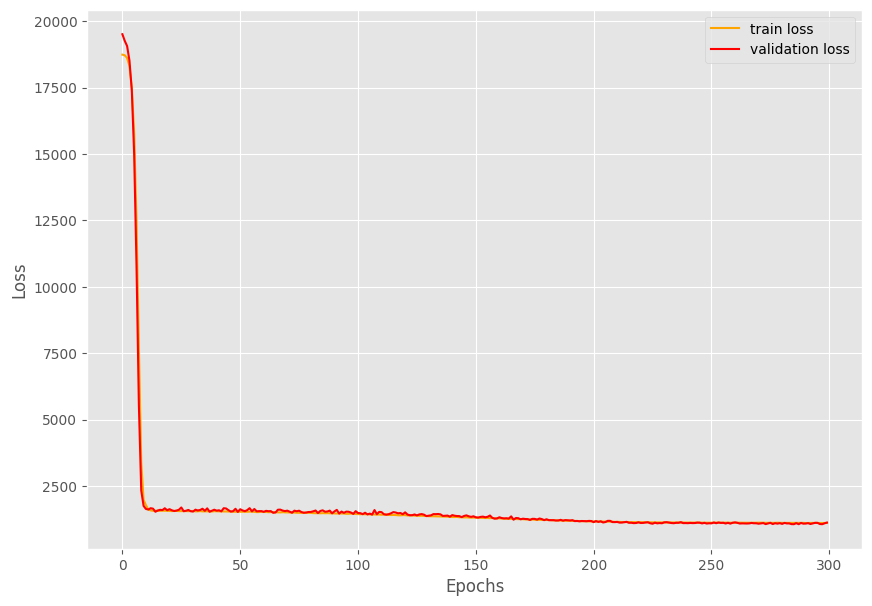

In [16]:
train_loss = []
val_loss = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    # 開始時刻及びフォーマット
    start_time = dt.datetime.now()
    formatted_start_time = start_time.strftime('%Y-%m-%d %H:%M:%S')

    # lap_time = end_time - start_time

    train_epoch_loss = fit(model,train_loader,train_tensor_data,optimizer,criterion)
    val_epoch_loss = validate(model,valid_loader,valid_tensor_data,criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    if epoch % 25 == 0:
        print(f"Train Loss: {train_epoch_loss:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}")

    # ラップタイムを計算する
    end_time = dt.datetime.now()
    lap_time = end_time - start_time

    record_progress_vram_information(f"{info_dir_path}/{now_str}_LossInfo.csv",epoch,formatted_start_time,lap_time,train_epoch_loss,val_epoch_loss)

plt.figure(figsize=(10,7))
plt.plot(train_loss,color="orange",label="train loss")
plt.plot(val_loss,color="red",label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"{info_dir_path}/loss.png")

torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, f"{info_dir_path}/model.pth")
print('DONE TRAINING')
